In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


In [5]:
# great to be here!
df = pd.read_csv('../input/weather-dataset-rattle-package/weatherAUS.csv')
print(df.shape)
df.head()

(145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
# pre processing the data

# check how many values are NaN in each column
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [7]:
# pick some columns for using in the model
cols = ['Rainfall', 'MaxTemp', 'Sunshine', 'Humidity3pm', 'Temp3pm', 'RainToday', 'RainTomorrow']
df = df[cols]

In [15]:
df.head()


,Rainfall,MaxTemp,Sunshine,Humidity3pm,Temp3pm,RainToday,RainTomorrow
0,0.6,22.9,NaN,22.0,21.8,0.0,No
1,0.0,25.1,NaN,25.0,24.3,0.0,No
2,0.0,25.7,NaN,30.0,23.2,0.0,No
3,0.0,28.0,NaN,16.0,26.5,0.0,No
4,1.0,32.3,NaN,33.0,29.7,0.0,No


In [21]:
df['RainToday']= df.RainToday.astype(object)
df['RainTomorrow'] = df.RainTomorrow.astype(object)

# convert Yes/No to 1/0
df['RainToday'].replace({'No':0, 'Yes':1}, inplace=True)
df['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace=True)

# df['RainToday']= df.RainToday.astype(int)
df.head()

,Rainfall,MaxTemp,Sunshine,Humidity3pm,Temp3pm,RainToday,RainTomorrow
0,0.6,22.9,NaN,22.0,21.8,0.0,0.0
1,0.0,25.1,NaN,25.0,24.3,0.0,0.0
2,0.0,25.7,NaN,30.0,23.2,0.0,0.0
3,0.0,28.0,NaN,16.0,26.5,0.0,0.0
4,1.0,32.3,NaN,33.0,29.7,0.0,0.0


In [23]:
# drop missing values
df = df.dropna(how='any')
print(df.shape)
df.head()

(73392, 7)


,Rainfall,MaxTemp,Sunshine,Humidity3pm,Temp3pm,RainToday,RainTomorrow
6049,0.0,35.2,12.3,13.0,33.4,0.0,0.0
6050,0.0,28.9,13.0,8.0,27.0,0.0,0.0
6051,0.0,34.1,13.3,7.0,32.7,0.0,0.0
6052,0.0,37.6,10.6,22.0,34.9,0.0,0.0
6053,0.0,38.4,12.2,22.0,35.6,0.0,0.0


In [37]:
# plot predictor variable: RainTomorrow
# sns.countplot(df.RainTomorrow) # need seaborn

# np.count_nonzero(df['RainTomorrow'])  # no. of days it rained 

df.RainTomorrow.value_counts()/df.shape[0]

# ~78% of the data corresponds to no rain tomorrow, quite unbalanced data!

0.0    0.776406
1.0    0.223594
Name: RainTomorrow, dtype: float64

In [45]:
# split train and test data
X = df[['Rainfall', 'MaxTemp', 'Sunshine', 'Humidity3pm', 'Temp3pm', 'RainToday']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [46]:
X_train.shape

(58713, 6)

In [47]:
X_test.shape

(14679, 6)

In [55]:
# convert train and test data to torch tensors
import torch
import torch.nn.functional as F
from torch import nn

X_train = torch.from_numpy(np.asarray(X_train)).float()
y_train = torch.squeeze(torch.from_numpy(np.asarray(y_train)).float()) #squeeze removes extra dimension 1 from y vector

X_test = torch.from_numpy(np.asarray(X_test)).float()
y_test = torch.squeeze(torch.from_numpy(np.asarray(y_test)).float())


In [56]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([58713, 6]) torch.Size([58713])
torch.Size([14679, 6]) torch.Size([14679])


In [57]:
# define a neural network

class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 6)
        self.fc2 = nn.Linear(6, 4)
        self.fc3 = nn.Linear(4, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [65]:
net = Net(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# using GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

# transfer data from RAM to GPU memory
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

cuda:0


In [66]:
# transfer(?) neural net and loss func to GPU as well..
net = net.to(device)
criterion = criterion.to(device)

In [81]:
# training
train_error = []
total_epochs = 5000
for epoch in range(total_epochs):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    train_error.append(train_loss)
    if(epoch % 200 ==0):
        print(train_loss.item())  # print the training loss
    optimizer.zero_grad()
    
    train_loss.backward()
    optimizer.step()
    
    

0.3760448694229126
0.37601953744888306
0.3759905993938446
0.3759705126285553
0.37597379088401794
0.37594282627105713
0.37593013048171997
0.3759058117866516
0.3758981227874756
0.37586119771003723
0.37400057911872864
0.37363770604133606
0.37349772453308105
0.37340885400772095
0.37331467866897583
0.37310758233070374
0.37296587228775024
0.3728618323802948
0.3727896511554718
0.37267956137657166
0.3725804090499878
0.3725586533546448
0.37254318594932556
0.37253662943840027
0.3725300431251526


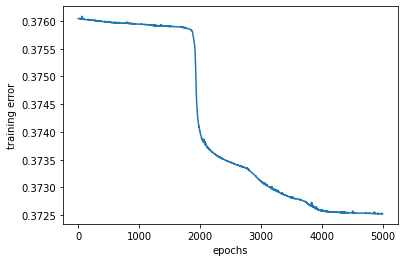

Final (train) Accuracy: tensor(62.7478, device='cuda:0', grad_fn=<MulBackward0>) %


In [90]:
from matplotlib import pyplot as plt

x_axes = np.linspace(1, total_epochs, total_epochs)
# print(x_axes)
plt.plot(x_axes, train_error)
plt.xlabel("epochs")
plt.ylabel("training error")
plt.show()

print("Final (train) Accuracy:", 100*(1- train_error[total_epochs-1]), "%")

In [85]:
# saving the model:
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

In [86]:
# load the model
net = torch.load(MODEL_PATH)

In [87]:
# Evaluation on test set
classes = ['No rain', 'Rain']
y_pred = net(X_test)  # getting output from the trained model

# thresholding on .5, get y_pred items to either 0 or 1. then load them to cpu
y_pred = y_pred.ge(.5).view(-1).cpu()

y_test = y_test.cpu()



In [89]:
# printing report using scikit-learn
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.86      0.95      0.90     11438
        Rain       0.72      0.45      0.55      3241

    accuracy                           0.84     14679
   macro avg       0.79      0.70      0.73     14679
weighted avg       0.83      0.84      0.82     14679

